<a href="https://colab.research.google.com/github/Simranjeet-Singh-1313/Jakarta-Ambulance-Service-Time-series-and-forecasting/blob/main/Time_Series_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install arch

     |████████████████████████████████| 808kB 7.5MB/s 


In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import scipy, os
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess


from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

from arch.unitroot import PhillipsPerron
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from arch import arch_model
from scipy.stats import shapiro
from scipy.stats import probplot
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# Set Base-directory 
basedir='/content/drive/MyDrive/Timeseries.Assignment'

## Preprocessing part

In [5]:
df=pd.read_excel(os.path.join(basedir,'TimeSeriesCourseworkData20_21.xlsx'))
df

,Call,City Municipality
0,2018-12-31 22:31:28,JAKARTA TIMUR
1,2018-12-31 23:46:09,JAKARTA TIMUR
2,2019-01-01 00:12:30,JAKARTA TIMUR
3,2019-01-01 01:16:56,JAKARTA TIMUR
4,2019-01-01 01:21:18,JAKARTA BARAT
...,...,...
22535,2019-05-31 23:02:44,JAKARTA PUSAT (KIARA)
22536,2019-05-31 23:06:28,JAKARTA PUSAT
22537,2019-05-31 23:35:12,JAKARTA PUSAT
22538,2019-05-31 23:45:00,JAKARTA PUSAT (KIARA)


In [6]:
df["Call_Date"]=[d.date() for d in df['Call']]
df["Call_Time"]=[d.time() for d in df["Call"]]
df=df.drop("Call",axis=1)
df

,City Municipality,Call_Date,Call_Time
0,JAKARTA TIMUR,2018-12-31,22:31:28
1,JAKARTA TIMUR,2018-12-31,23:46:09
2,JAKARTA TIMUR,2019-01-01,00:12:30
3,JAKARTA TIMUR,2019-01-01,01:16:56
4,JAKARTA BARAT,2019-01-01,01:21:18
...,...,...,...
22535,JAKARTA PUSAT (KIARA),2019-05-31,23:02:44
22536,JAKARTA PUSAT,2019-05-31,23:06:28
22537,JAKARTA PUSAT,2019-05-31,23:35:12
22538,JAKARTA PUSAT (KIARA),2019-05-31,23:45:00


In [7]:
df["Number_of_Calls"]=df["Call_Date"].map(df.groupby("Call_Date").size())
df=df.drop_duplicates("Call_Date")
df.head(5)

,City Municipality,Call_Date,Call_Time,Number_of_Calls
0,JAKARTA TIMUR,2018-12-31,22:31:28,2
2,JAKARTA TIMUR,2019-01-01,00:12:30,102
104,JAKARTA TIMUR,2019-01-02,00:28:18,163
267,JAKARTA BARAT,2019-01-03,00:21:21,174
441,JAKARTA BARAT,2019-01-04,00:08:08,176


In [8]:
df.tail(10)

,City Municipality,Call_Date,Call_Time,Number_of_Calls
21123,JAKARTA BARAT,2019-05-22,00:20:09,86
21209,JAKARTA SELATAN,2019-05-23,02:39:40,160
21369,JAKARTA PUSAT,2019-05-24,00:01:39,151
21520,JAKARTA TIMUR,2019-05-25,00:01:12,118
21638,JAKARTA UTARA,2019-05-26,00:07:08,104
21742,JAKARTA BARAT,2019-05-27,00:18:12,178
21920,JAKARTA BARAT,2019-05-28,00:26:41,202
22122,JAKARTA UTARA,2019-05-29,00:06:38,158
22280,JAKARTA PUSAT,2019-05-30,00:02:56,131
22411,JAKARTA PUSAT,2019-05-31,00:37:24,129


In [9]:
df=df.drop(["City Municipality","Call_Time"],axis=1)
df

,Call_Date,Number_of_Calls
0,2018-12-31,2
2,2019-01-01,102
104,2019-01-02,163
267,2019-01-03,174
441,2019-01-04,176
...,...,...
21742,2019-05-27,178
21920,2019-05-28,202
22122,2019-05-29,158
22280,2019-05-30,131


In [10]:
df.tail(10)

,Call_Date,Number_of_Calls
21123,2019-05-22,86
21209,2019-05-23,160
21369,2019-05-24,151
21520,2019-05-25,118
21638,2019-05-26,104
21742,2019-05-27,178
21920,2019-05-28,202
22122,2019-05-29,158
22280,2019-05-30,131
22411,2019-05-31,129


In [11]:
df=df.set_index("Call_Date")
df.head()

,Number_of_Calls
Call_Date,
2018-12-31,2
2019-01-01,102
2019-01-02,163
2019-01-03,174
2019-01-04,176


In [12]:
df

,Number_of_Calls
Call_Date,
2018-12-31,2
2019-01-01,102
2019-01-02,163
2019-01-03,174
2019-01-04,176
...,...
2019-05-27,178
2019-05-28,202
2019-05-29,158


In [13]:
# remove first value of data which is outlier 
df=df[1:]
df

,Number_of_Calls
Call_Date,
2019-01-01,102
2019-01-02,163
2019-01-03,174
2019-01-04,176
2019-01-05,120
...,...
2019-05-27,178
2019-05-28,202
2019-05-29,158


In [14]:
df.describe()

,Number_of_Calls
count,151.000000
mean,149.258278
std,32.789727
min,82.000000
25%,120.000000
50%,158.000000
75%,173.500000
max,242.000000


In [15]:
df

,Number_of_Calls
Call_Date,
2019-01-01,102
2019-01-02,163
2019-01-03,174
2019-01-04,176
2019-01-05,120
...,...
2019-05-27,178
2019-05-28,202
2019-05-29,158


## Define function

In [16]:
#helper function to plot the time series data
def plot_pred(pred,title):
    plt.figure(figsize=(17,5))
    plt.plot(train_data,label='Train')
    plt.plot(test_data,label='Actual')
    plt.plot(pred,label='Predicted')
    plt.ylabel("Jakarta Ambulance Prediction")
    plt.title(title,fontsize=20)
    plt.legend()
    plt.show()

In [17]:
# Function Check_data check what percentage of data lies in the range mean +_ 3*sigma
def check_data(x):
    sigma = x.std()
    mean = x.mean()
    c = 0 
    for i in range(len(x)):
        if x[i] > (mean -3*sigma) and x[i] < (mean + 3*sigma):
            c = c + 1
    per_data = (c/len(x))*100

    print(f'Percentage of data between mean-3*sigma and mean+3*sigma is : {per_data}')
    

In [18]:

#define function for ADF test
def Adf_test(series):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p_value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    print(f'Result: The series is {"not " if dftest[1] > 0.05 else ""}stationary')
          

In [19]:
#Define function for KPSS test
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

In [20]:
# Define function for PP test
def pp_test(series):    
    pp = PhillipsPerron(series)
    print(pp.summary().as_text())

In [21]:
import math
# WE will check if there is some missing value
df = df.Number_of_Calls
miss = []
for j in range(len(df)):
    if math.isnan(df[j])== True:
        miss.append(j)
print(miss)

[]


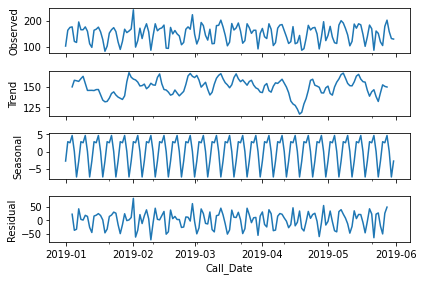

<Figure size 1296x1080 with 0 Axes>

In [22]:
#Plot Decomposition Figure
decomposed=sm.tsa.seasonal_decompose(df,model="additive",freq=6)
figure = decomposed.plot()
plt.figure(figsize=(18,15))
plt.show()

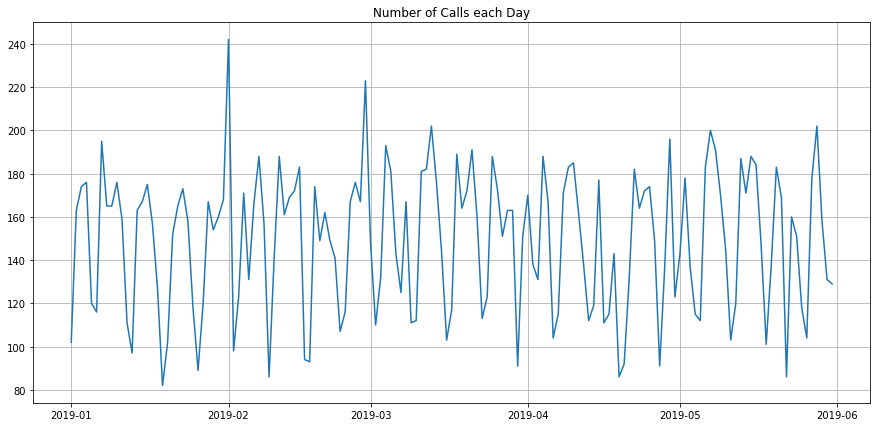

In [23]:
# PLOT the given time series data
plt.figure(figsize=(15, 7))
plt.plot(df)
plt.title('Number of Calls each Day')
plt.grid(True)
plt.show()

In [24]:
#split dataset into training set and testing set
train_data = df[:-45]
test_data = df[-45:]

# print(train_data)
# print(test_data)

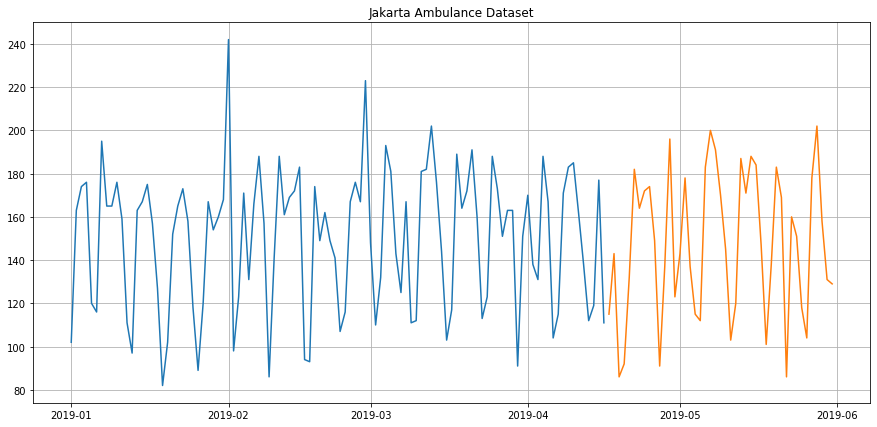

In [25]:
# PLOT the Train and Test Data in a single plot
plt.figure(figsize=(15, 7))
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.title('Jakarta Ambulance Dataset')
plt.grid(True)
plt.show()

## Linear Regression

In [26]:
df=pd.DataFrame(df)

In [27]:
X=np.arange(df.index.size)
fit=np.polyfit(X,df.Number_of_Calls,deg=1)
print("slope :"+str(fit[0]))
print("Intercept :"+str(fit[1]))


slope :0.00034855350296221667
Intercept :149.23213663297318


In [28]:
fit_Function=np.poly1d(fit)

In [29]:
Lin_Reg_Pre=fit_Function(X)

In [30]:
Pre_Date=pd.date_range(start="2019-01-01",end="2019-05-31",freq="D")
Pre_Date=pd.DataFrame(Pre_Date)
Pre_Date.columns=['Date']
Pre_Date.set_index(['Date'],inplace=True)
Pre_Date["Number_of_Calls"]=Lin_Reg_Pre


In [31]:
MSE=mean_squared_error(Pre_Date,df)
RMSE=np.sqrt(MSE)
MAE=mean_absolute_error(Pre_Date,df)
print("The Mean Squar error of Linear Regression model is: ",MSE)
print("The Root Mean Squre error of Linear Regression Model is:",RMSE)
print("The Mean Absolute error of Linear Regression Model is:",MAE)

The Mean Squar error of Linear Regression model is:  1068.045644350779
The Root Mean Squre error of Linear Regression Model is: 32.68096761650088
The Mean Absolute error of Linear Regression Model is: 27.823502662625593


In [32]:
prediction = fit_Function(df.index.size + 7)
print("Prediction of Linear Regression:",prediction)

Prediction of Linear Regression: 149.2872080864412


In [33]:
pri=list(np.repeat(prediction,7))

In [34]:
Prediction_Date=pd.date_range(start="2019-06-01",end="2019-06-07",freq="D")
Prediction_Date=pd.DataFrame(Prediction_Date)
Prediction_Date.columns=['Date']
Prediction_Date.set_index(['Date'],inplace=True)
Prediction_Date["Number_of_Calls"]=pri
Prediction_Date

,Number_of_Calls
Date,
2019-06-01,149.287208
2019-06-02,149.287208
2019-06-03,149.287208
2019-06-04,149.287208
2019-06-05,149.287208
2019-06-06,149.287208
2019-06-07,149.287208


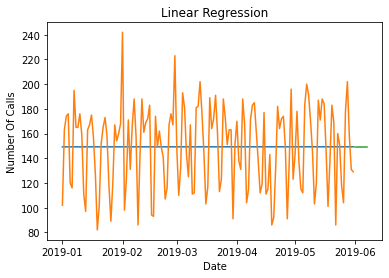

In [35]:
plt.plot(df.index,fit_Function(X))
plt.plot(df.index,df.Number_of_Calls,)
plt.plot(Prediction_Date)
plt.xlabel('Date')
plt.ylabel('Number Of Calls')
plt.title('Linear Regression')
plt.show()

## Mean Method




In [36]:
# Mean of previous values

y_av = pd.Series(np.repeat(train_data.mean(),45),index=test_data.index)
MSE=mean_squared_error(y_av,test_data)
RMSE=np.sqrt(MSE)
MAE=mean_absolute_error(y_av,test_data)
print("The Mean Squar error of Mean model model is: ",MSE)
print("The Root Mean Squre error of Mean Model is:",RMSE)
print("The Mean Absolute error of Mean Model is:",MAE)

The Mean Squar error of Mean model model is:  1120.3111111111111
The Root Mean Squre error of Mean Model is: 33.471048849880866
The Mean Absolute error of Mean Model is: 28.755555555555556


In [37]:
Average_pre=pd.date_range(start="2019-06-01",end="2019-06-07",freq="D")
Average_pre=pd.DataFrame(Average_pre)
Average_pre.columns=['Date']
Average_pre.set_index(['Date'],inplace=True)
mean=float(test_data.mean())
Average_pre["Number_of_Calls"]=mean
Average_pre

,Number_of_Calls
Date,
2019-06-01,147.511111
2019-06-02,147.511111
2019-06-03,147.511111
2019-06-04,147.511111
2019-06-05,147.511111
2019-06-06,147.511111
2019-06-07,147.511111


In [38]:
Average_pre=Average_pre.squeeze()

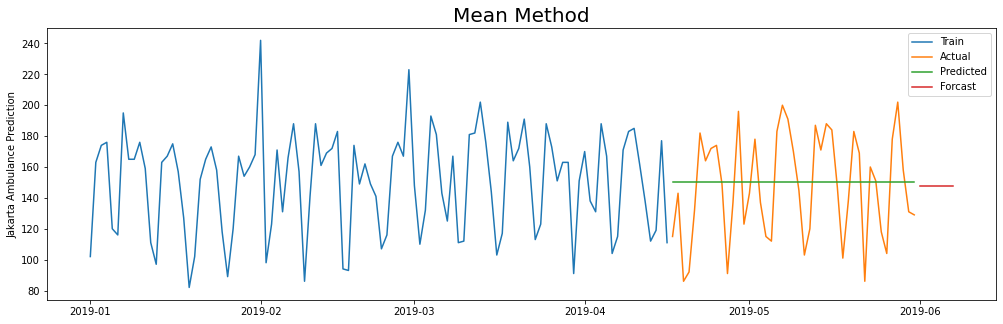

In [39]:
plt.figure(figsize=(17,5))
plt.plot(train_data,label='Train')
plt.plot(test_data,label='Actual')
plt.plot(y_av,label='Predicted')
plt.plot(Average_pre,label="Forcast")
plt.ylabel("Jakarta Ambulance Prediction")
plt.title("Mean Method",fontsize=20)
plt.legend()
plt.show()

## Moving Average

In [40]:
# Moving Average Of Three Days
moving_Ave=test_data.rolling(3).mean()

In [41]:
List=[179.33333,163.6667,139.3334]
for i in range(7):
  Three_day_Moving_AVG=(List[-1]+List[-2]+List[-3])/3
  List.append(Three_day_Moving_AVG)
new_list=List[3:]

In [42]:
# Forecasting through moving Average model.
Mov_Avg_For=pd.date_range(start="2019-06-01",end="2019-06-07",freq="D")
Mov_Avg_For=pd.DataFrame(Mov_Avg_For)
Mov_Avg_For.columns=['Date']
Mov_Avg_For.set_index(['Date'],inplace=True)
Mov_Avg_For["Number_of_Calls"]=new_list
Mov_Avg_For

,Number_of_Calls
Date,
2019-06-01,160.777810
2019-06-02,154.592637
2019-06-03,151.567949
2019-06-04,155.646132
2019-06-05,153.935572
2019-06-06,153.716551
2019-06-07,154.432752


In [43]:
moving_Ave.dropna(axis=0,inplace=True)

In [44]:
MSE=mean_squared_error(moving_Ave,test_data[2:])
RMSE=np.sqrt(MSE)
MAE=mean_absolute_error(moving_Ave,test_data[2:])
print("The Mean Squar error of Moving Average model is: ",MSE)
print("The Root Mean Squre error of Moving Average Model is:",RMSE)
print("The Mean Absolute error of Moving Average Model is:",MAE)

The Mean Squar error of Moving Average model is:  839.4677002583979
The Root Mean Squre error of Moving Average Model is: 28.973568994143577
The Mean Absolute error of Moving Average Model is: 24.062015503875966


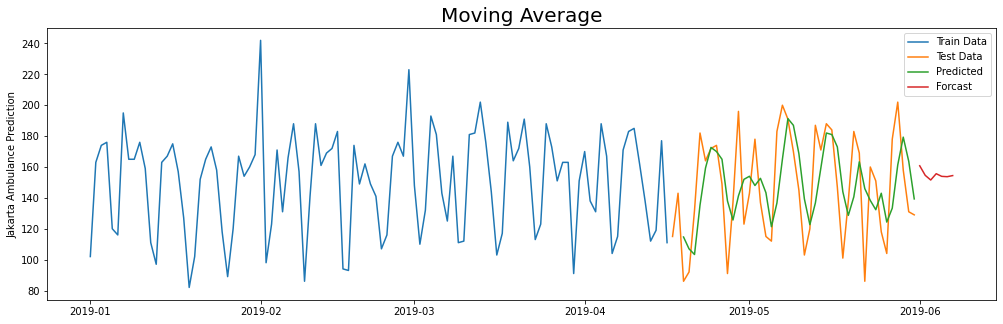

In [45]:
plt.figure(figsize=(17,5))
plt.plot(train_data,label='Train Data')
plt.plot(test_data,label='Test Data')
plt.plot(moving_Ave,label='Predicted')
plt.plot(Mov_Avg_For,label="Forcast")
plt.ylabel("Jakarta Ambulance Prediction")
plt.title("Moving Average",fontsize=20)
plt.legend()
plt.show()

In [46]:

k = train_data.kurtosis()
s = train_data.skew()
print(f'Kurtosis: {k}')
print(f'skew: {s}')

Kurtosis: -0.45864945020559
skew: -0.17345013628659187


In [47]:
# Check the data Lie between Mean-3*sigma and Mean+3*sigma
check_data(train_data)

Percentage of data between mean-3*sigma and mean+3*sigma is : 100.0


## Autocorrelation and PartialAutocorrelation


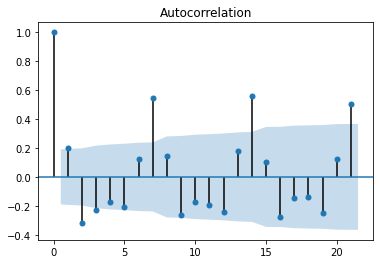

In [48]:
plot_acf(train_data)
plt.show()

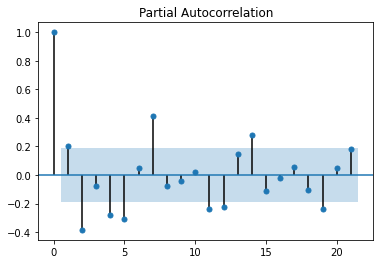

In [49]:
plot_pacf(train_data)
plt.show()

##Detection Stationary 

In [50]:
df=pd.DataFrame(df)

In [51]:
Adf_test(train_data)

Results of Dickey-Fuller Test:
Test Statistic                 -2.078493
p_value                         0.253250
#Lags Used                     13.000000
Number of Observations Used    92.000000
Critical Value (1%)            -3.503515
Critical Value (5%)            -2.893508
Critical Value (10%)           -2.583824
dtype: float64
Result: The series is not stationary


In [52]:
# warnings.filterwarnings('ignore')
kpss_test(train_data)

KPSS Statistic: 0.16516930342364178
p-value: 0.1
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [53]:
pp_test(train_data)

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -8.980
P-value                         0.000
Lags                               13
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


## Converting Series into Log


In [54]:
#converting series into log serie to get stationary series
df['log_ret'] = np.log(df) - np.log(df.shift(1))
r_t = df['log_ret']
print(r_t)

Call_Date
2019-01-01         NaN
2019-01-02    0.468777
2019-01-03    0.065305
2019-01-04    0.011429
2019-01-05   -0.382992
                ...   
2019-05-27    0.537393
2019-05-28    0.126484
2019-05-29   -0.245673
2019-05-30   -0.187398
2019-05-31   -0.015385
Name: log_ret, Length: 151, dtype: float64


In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
# Here we drop all NaN value
r_t = r_t.dropna()
print(r_t)

Call_Date
2019-01-02    0.468777
2019-01-03    0.065305
2019-01-04    0.011429
2019-01-05   -0.382992
2019-01-06   -0.033902
                ...   
2019-05-27    0.537393
2019-05-28    0.126484
2019-05-29   -0.245673
2019-05-30   -0.187398
2019-05-31   -0.015385
Name: log_ret, Length: 150, dtype: float64


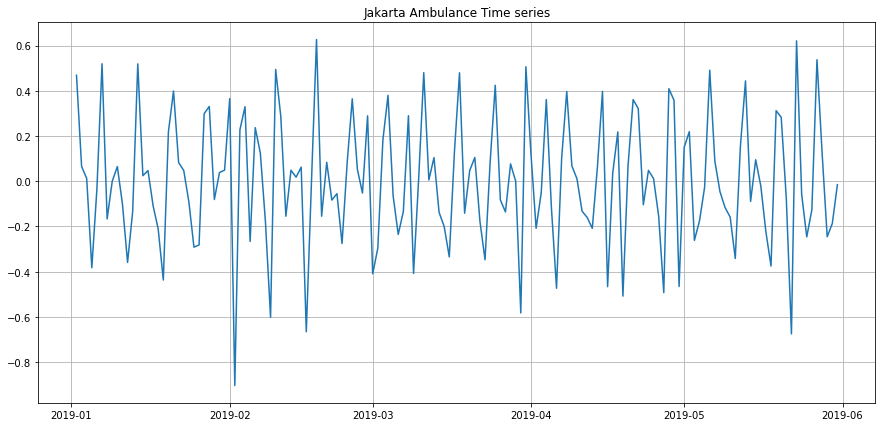

In [57]:
plt.figure(figsize=(15, 7))
plt.plot(r_t)
plt.title('Jakarta Ambulance Time series')
plt.grid(True)
plt.show()

In [58]:
# Break the data as test and train Data

logtrain_data = r_t[:-45]
logtest_data = r_t[-45:]
# print(logtrain_data)
# print(logtest_data)

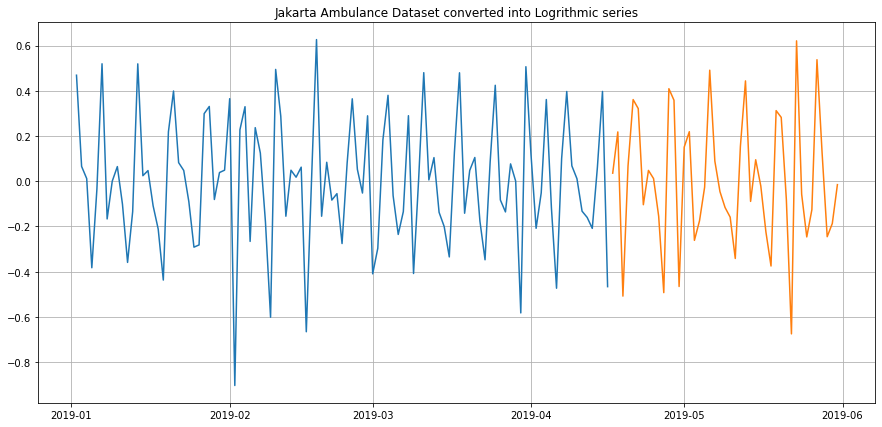

In [59]:
# PLot the logtrain and logtest data in a single ts graph

plt.figure(figsize=(15, 7))
plt.plot(logtrain_data.index, logtrain_data)
plt.plot(logtest_data.index, logtest_data)
plt.title('Jakarta Ambulance Dataset converted into Logrithmic series')
plt.grid(True)
plt.show()

In [60]:
logtrain_data.describe()

count    105.000000
mean       0.000805
std        0.287997
min       -0.903970
25%       -0.160343
50%        0.010870
75%        0.127445
max        0.626456
Name: log_ret, dtype: float64

In [61]:
k = logtrain_data.kurtosis()
s = logtrain_data.skew()
print(f'Kurtosis: {k}')
print(f'skew: {s}')

Kurtosis: 0.23101601326742438
skew: -0.20684667129997258


In [62]:
check_data(logtrain_data)

Percentage of data between mean-3*sigma and mean+3*sigma is : 99.04761904761905


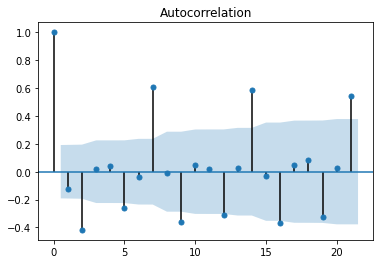

In [63]:
plot_acf(logtrain_data)
plt.show()

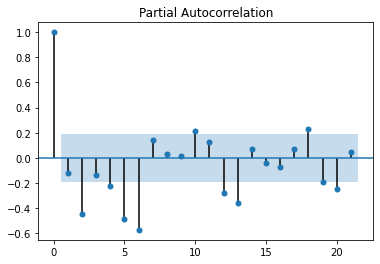

In [64]:

plot_pacf(logtrain_data)
plt.show()

In [65]:
df_new=pd.DataFrame(logtrain_data)
# df_new

## Stationary Detection After converting  Log series


In [66]:
Adf_test(logtrain_data)

Results of Dickey-Fuller Test:
Test Statistic                 -5.236201
p_value                         0.000007
#Lags Used                     12.000000
Number of Observations Used    92.000000
Critical Value (1%)            -3.503515
Critical Value (5%)            -2.893508
Critical Value (10%)           -2.583824
dtype: float64
Result: The series is stationary


In [67]:
kpss_test(logtrain_data)

KPSS Statistic: 0.30305261044715265
p-value: 0.1
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [68]:
pp_test(logtrain_data)

     Phillips-Perron Test (Z-tau)    
Test Statistic                -31.419
P-value                         0.000
Lags                               13
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


## ARIMA Model

In [69]:
# for paprameter selection 
# Input m and n are the maximum possible value of parameter p and q respectively.
def par_sel (m,n):
    AB = {}
    for p in range(m):
        for q in range(n):
            try:
                mod = ARIMA(logtrain_data, order= (p,0,q))
                result = mod.fit()
                AB[(p,q)] = [result.aic, result.bic]
            except:
                continue
    return AB

In [70]:
import warnings
warnings.filterwarnings("ignore")
par_sel (5,5)

{(0, 0): [39.563441162176645, 44.87136186249169],
 (0, 1): [1.242980097200757, 9.204861147673327],
 (0, 2): [-11.546798947977777, -0.9309575473476848],
 (0, 3): [-19.710672495337576, -6.440870744549962],
 (1, 0): [39.929802148291, 47.89168319876357],
 (1, 1): [-2.3535686774148417, 8.26227272321525],
 (2, 0): [18.30984815126726, 28.925689551897353],
 (2, 1): [-18.97497956008749, -5.705177809299876],
 (2, 2): [-22.925500110623204, -7.001738009678064],
 (3, 0): [18.2960629081349, 31.565864658922514],
 (3, 1): [-17.25111292015265, -1.3273508192075099],
 (3, 2): [-17.958316766303085, 0.6194056847995739],
 (4, 0): [14.81638862881357, 30.74015072975871],
 (4, 1): [-26.670983464876656, -8.093261013773997],
 (4, 2): [-29.310953560786913, -8.079270759526729]}

In [71]:

# FIT appropriate ARIMA model
p = 4
q = 2
mod = ARIMA(logtrain_data, order =(p,0,q))
result = mod.fit()
print(result.aic)

# Compare AIC and BIC value for p = 2 and q = 4
print(result.aic, result.bic)

-29.310953560786913
-29.310953560786913 -8.079270759526729


In [72]:
#Forecast on logtest_data
history = [x for x in logtrain_data]
predictions = list()
for t in range(len(logtest_data)):
    model= ARIMA(history, order=(4,0,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = logtest_data[t]
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_data, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 22866.058


In [73]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  149
Model:                     ARMA(4, 2)   Log Likelihood                  25.593
Method:                       css-mle   S.D. of innovations              0.199
Date:                Fri, 04 Jun 2021   AIC                            -35.185
Time:                        18:32:27   BIC                            -11.154
Sample:                             0   HQIC                           -25.422
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.571e-05      0.000      0.100      0.920      -0.000       0.001
ar.L1.y        0.6052      0.149      4.058      0.000       0.313       0.898
ar.L2.y       -0.6075      0.100     -6.099      0.000      -0.803      -0.412
ar.L3.y        0.2061      0.103      1.994      0.048       0.003       0.409
ar.L4.y       -0.2824      0.079     -3.558      0.001      -0.438      -0.127
ma.L1.y       -1.2844      0.142     -9.045      0.000      -1.563      -1.006
ma.L2.y        0.2844      0.140      2.032      0.044       0.010       0.559
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8509           -0.9468j            1.2730           -0.1335
AR.2            0.8509           +0.9468j            1.2730            0.1335
AR.3           -0.4860           -1.3959j            1.4781           -0.3033
AR.4           -0.4860           +1.3959j            1.4781            0.3033
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2            3.5157           +0.0000j            3.5157            0.0000
-----------------------------------------------------------------------------
"""

In [74]:
fin_pred = [train_data[-1]]
# print(fin_pred)
for i in range(len(test_data)):
    x = fin_pred[-1]
    y = predictions[i]
    fin_pred.append(x*math.exp(y))
fin_pred = fin_pred[1:]

In [75]:
# for j in range(len(fin_pred)):
    # print(fin_pred[j],":", test_data[j])

In [76]:
MSE= mean_squared_error(fin_pred, test_data)
RMSE=np.sqrt(MSE)
MAE=mean_absolute_error(fin_pred, test_data)
print("The Mean Squar error of ARIMA model is: ",MSE)
print("The Root Mean Squre error of ARIMA Model is:",RMSE)
print("The Mean Absolute error of ARIMA Model is:",MAE)


The Mean Squar error of ARIMA model is:  7032.918661093881
The Root Mean Squre error of ARIMA Model is: 83.86249853834478
The Mean Absolute error of ARIMA Model is: 66.65079192786739


In [77]:
# for paprameter selection 
# Input m and n are the maximum possible value of parameter p and q respectively.
def par_sel (m,n):
    AB = {}
    for p in range(m):
        for q in range(n):
            try:
                mod = ARIMA(logtest_data, order= (p,0,q))
                result = mod.fit()
                AB[(p,q)] = [result.aic, result.bic]
            except:
                continue
    return AB

In [78]:
import warnings
warnings.filterwarnings("ignore")
par_sel (5,5)

{(0, 0): [21.069346294806483, 24.682671274347122],
 (0, 1): [9.767640612980514, 15.187628082291473],
 (0, 2): [3.837281812627239, 11.063931771708518],
 (1, 0): [22.443600613096223, 27.863588082407183],
 (1, 1): [8.077061511147448, 15.303711470228727],
 (2, 0): [11.872709629298981, 19.09935958838026],
 (2, 1): [3.000118725797236, 12.033431174648832],
 (2, 2): [4.589532607951881, 15.429507546573799],
 (3, 0): [11.740226527643088, 20.773538976494685],
 (3, 1): [4.5928627686054, 15.432837707227318],
 (3, 2): [6.801291523035971, 19.44792895142821],
 (4, 0): [13.731604428438004, 24.571579367059922],
 (4, 1): [6.161796365286975, 18.808433793679214],
 (4, 2): [6.9811889623805, 21.434488880543057]}

In [79]:
history_1=[x for x in logtest_data]
forcast_ARIMA=ARIMA(history_1,order=(2,0,1)).fit()
forcast1=forcast_ARIMA.forecast(7)

In [80]:
forcast_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   45
Model:                     ARMA(2, 1)   Log Likelihood                   3.500
Method:                       css-mle   S.D. of innovations              0.214
Date:                Fri, 04 Jun 2021   AIC                              3.000
Time:                        18:32:31   BIC                             12.033
Sample:                             0   HQIC                             6.368
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.002      1.163      0.252      -0.002       0.007
ar.L1.y        0.3685      0.137      2.684      0.010       0.099       0.638
ar.L2.y       -0.3819      0.136     -2.816      0.007      -0.648      -0.116
ma.L1.y       -1.0000      0.090    -11.051      0.000      -1.177      -0.823
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.4824           -1.5445j            1.6181           -0.2018
AR.2            0.4824           +1.5445j            1.6181            0.2018
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [81]:
Arima_for=pd.date_range(start="2019-06-01",end="2019-06-07",freq="D")
Arima_for=pd.DataFrame(Arima_for)
Arima_for.columns=['Date']
Arima_for.set_index(['Date'],inplace=True)
# Arima_for

In [82]:
Number_of_Calls=list()
for i in list(range(len(Arima_for))):
  X=forcast1[0][i]
  # print(type(X))
  Number_of_Calls.append(X)
# Number_of_Calls

In [83]:
final_prediction = [test_data[-1]]
for i in range(len(Arima_for)):
    x = final_prediction[-1]
    y = Number_of_Calls[i]
    final_prediction.append(x*math.exp(y))
final_prediction= final_prediction[1:]

In [84]:
# print Dataframe for Prediction Of Number Of Calls by ARIMA 
Arima_for["Number_of_Calls"]=final_prediction
Arima_for

,Number_of_Calls
Date,
2019-06-01,152.340536
2019-06-02,163.384053
2019-06-03,157.780461
2019-06-04,152.085928
2019-06-05,152.483955
2019-06-06,155.227418
2019-06-07,156.537135


In [85]:
print(df.Number_of_Calls.mean(),np.sqrt(df.Number_of_Calls.var()))

149.25827814569536 32.78972676030485


In [86]:
test_data=pd.DataFrame(test_data)
test_data
new_df=test_data.drop("Number_of_Calls",axis=1)
fin_pred=pd.DataFrame(fin_pred)
# fin_pred

In [87]:
new_df.index
fin_pred.index=new_df.index
fin_pred.columns=["Number_of_predicted_Calls"]

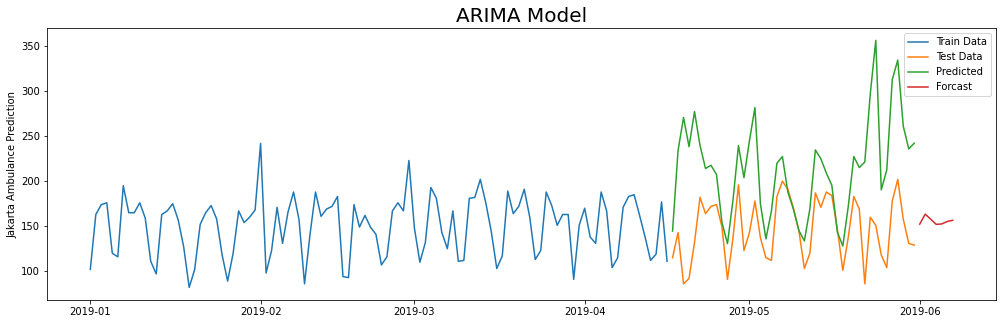

In [88]:
#Plot Arima Model
plt.figure(figsize=(17,5))
plt.plot(train_data,label='Train Data')
plt.plot(test_data,label='Test Data')
plt.plot(fin_pred,label='Predicted')
plt.plot(Arima_for,label="Forcast")
plt.ylabel("Jakarta Ambulance Prediction")
plt.title("ARIMA Model",fontsize=20)
plt.legend()
plt.show()

# HOLT Winters

In [89]:
# Holt Winter Model fit on training set
model=ExponentialSmoothing(logtrain_data,trend='additive',seasonal='add',seasonal_periods=29).fit()

In [90]:
# test_forcast=holt_win_model.forecast(46)
test_forcast=model.predict(start="2019-04-17",end="2019-05-31")

In [91]:
final_forcast=[train_data[-1]]
for i in range(len(test_forcast)):
  x=final_forcast[-1]
  y=test_forcast[i]
  final_forcast.append(x*math.exp(y))
holt_forcast1=pd.DataFrame(final_forcast)
holt_forcast1["Call_Date"]=pd.date_range(start="2019-04-16",end="2019-05-31",freq="D")
holt_forcast1.index=holt_forcast1["Call_Date"]

In [92]:
MSE = mean_squared_error(final_forcast[1:], test_data)
RMSE=np.sqrt(MSE)
MAE=mean_absolute_error(final_forcast[1:], test_data)
print("The Mean Squar error of Holt Winter model is: ",MSE)
print("The Root Mean Squre error of Holt Winter Model is:",RMSE)
print("The Mean Absolute error of Holt Winter Model is:",MAE)

The Mean Squar error of Holt Winter model is:  2245.8129040031763
The Root Mean Squre error of Holt Winter Model is: 47.39000848283503
The Mean Absolute error of Holt Winter Model is: 39.14653826323907


In [93]:
holt_forcast1.drop(["Call_Date"],inplace=True,axis=1)

In [94]:
holt_win_model=ExponentialSmoothing(logtest_data,trend='additive',seasonal='additive',seasonal_periods=7).fit()

In [95]:
test_pred1=holt_win_model.predict(start="2019-06-01",end="2019-06-07")

In [96]:
final_pred=[test_data.Number_of_Calls[-1]]
for i in range(len(test_pred1)):
  x=final_pred[-1]
  y=test_pred1[i]
  final_pred.append(x*math.exp(y))
holt_pre=pd.DataFrame(final_pred)
holt_pre["Call_Date"]=pd.date_range(start="2019-06-01",periods=8,freq="D")
# holt_pre.index=test_pred.index

In [97]:
holt_pre=holt_pre[:7]
holt_pre=holt_pre.set_index("Call_Date")
holt_pre=holt_pre.set_axis(['Number_of_Calls'], axis='columns')
holt_pre=holt_pre.set_axis(['Number_of_Calls'], axis='columns')

In [98]:
# Print DataFrame of Holt Winter Prediction Number Of Calls
holt_pre

,Number_of_Calls
Call_Date,
2019-06-01,129.000000
2019-06-02,96.862678
2019-06-03,107.580058
2019-06-04,162.088870
2019-06-05,154.802544
2019-06-06,123.071609
2019-06-07,133.968696


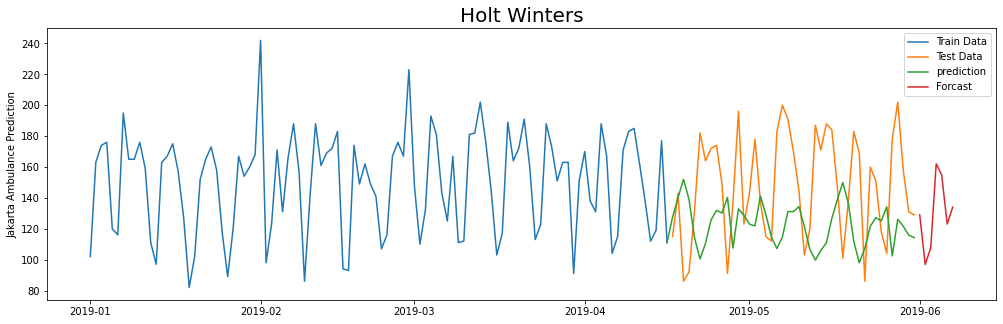

In [99]:
# Plot Holt Winter Method
plt.figure(figsize=(17,5))
plt.plot(train_data,label='Train Data')
plt.plot(test_data,label='Test Data')
plt.plot(holt_forcast1,label='prediction')
plt.plot(holt_pre,label='Forcast')
plt.ylabel("Jakarta Ambulance Prediction")
plt.title("Holt Winters",fontsize=20)
plt.legend()
plt.show()